In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pbn import operations as ops
from pbn import conversions as convert
from pbn import functions as fxn
from scipy import ndimage
%matplotlib inline

In [3]:
def get_na_counts(df):
    return df.apply(pd.Series.isnull).apply(pd.Series.value_counts)

(900, 723, 3)


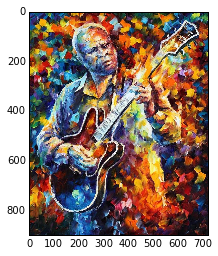

In [4]:
import matplotlib.image as matimg
#img_d = matimg.imread('/Users/eczech/Downloads/google.png')
img_rgb = matimg.imread('/Users/eczech/Downloads/afrimov_bbking.png')
print(img_rgb.shape)
plt.imshow(img_rgb)

In [5]:
img_rgb = img_rgb[:200,:400,:]

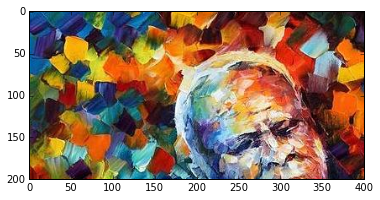

In [6]:
plt.imshow(img_rgb)

In [7]:
img_lab = convert.rgb_to_lab(img_rgb)

In [8]:
def unravel(d, color_cols=['l', 'a', 'b']):
    n2d = d.shape[0] * d.shape[1]
    colors = np.empty((n2d, 5))
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            z = i * d.shape[1] + j
            colors[z] = [float(i), float(j)] + list(d[i, j, :])
    return pd.DataFrame(colors, columns=['x', 'y'] + color_cols)

In [126]:
#alpha = .002 # best so far for gmm
#alpha = .004 # also good for gmm
alpha = 4
img_df = unravel(img_lab)
img_df[['l', 'a', 'b']] = img_df[['l', 'a', 'b']] * alpha
img_df.head()

,x,y,l,a,b
0,0,0,138.337586,17.246894,-164.449224
1,0,1,246.500256,-27.041969,-161.877610
2,0,2,181.279492,-9.070585,-160.252197
3,0,3,181.279492,-9.070585,-160.252197
4,0,4,161.636972,-1.464219,-158.473614


In [127]:
from sklearn.mixture import DPGMM, GMM
#mm = DPGMM(n_components=500, alpha=.1, n_iter=50)
mm = GMM(n_components=150)
mm.fit(img_df)
img_pred = mm.predict(img_df)

In [128]:
mm.converged_

True

In [129]:
len(np.unique(img_pred))

150

In [130]:
mm.means_.shape

(150, 5)

In [131]:
img_all = pd.concat([img_df, pd.Series(img_pred)], axis=1)
img_all = img_all.rename(columns={0: 'c'})
img_all.index.name = 'order'
img_all.head()

,x,y,l,a,b,c
order,,,,,,
0,0,0,138.337586,17.246894,-164.449224,92
1,0,1,246.500256,-27.041969,-161.877610,85
2,0,2,181.279492,-9.070585,-160.252197,92
3,0,3,181.279492,-9.070585,-160.252197,92
4,0,4,161.636972,-1.464219,-158.473614,92


In [132]:
len(img_all['c'].unique())

150

In [133]:
color_clusters = img_all.groupby('c')[['l', 'a', 'b']].mean()
color_clusters.head()

,l,a,b
c,,,
0,200.601864,-82.106080,-42.904111
1,138.487121,213.930056,177.233517
2,335.839030,43.441471,101.095043
3,110.732265,152.793413,121.056455
4,196.040324,-56.413855,-32.894545


In [134]:
n_before = len(img_all)
img_merged = img_all.reset_index()\
    .merge(color_clusters.reset_index(), on='c', suffixes=['', '_m'])\
    .sort('order').set_index('order')
assert n_before == len(img_merged),\
    'Some rows were somehow lost during join: size before = {}, size after = {}'.format(n_before, len(img_merged))
assert np.all(img_merged.apply(np.isfinite).apply(np.all)), 'Merged data frame has NA values somehow'
img_merged.iloc[1000:1010]

,x,y,l,a,b,c,l_m,a_m,b_m
order,,,,,,,,,
1000,2,200,258.832566,80.782967,272.345293,73,284.619362,45.282696,284.553991
1001,2,201,223.813144,100.218454,251.988169,41,234.891536,109.830175,233.588625
1002,2,202,199.494035,119.084978,233.200565,41,234.891536,109.830175,233.588625
1003,2,203,202.434111,127.477044,236.477365,41,234.891536,109.830175,233.588625
1004,2,204,203.975005,136.190725,238.621000,43,229.386185,168.490658,252.154406
1005,2,205,196.389346,145.771308,233.208532,43,229.386185,168.490658,252.154406
1006,2,206,205.376749,148.420813,241.016496,43,229.386185,168.490658,252.154406
1007,2,207,226.910631,151.483248,246.952728,43,229.386185,168.490658,252.154406
1008,2,208,220.038749,161.987738,249.122410,43,229.386185,168.490658,252.154406


In [135]:
import imp
imp.reload(convert)
imp.reload(ops)
imp.reload(fxn)

<module 'pbn.functions' from '/Users/eczech/repos/portfolio/functional/paint_by_numbers/python/pbn/functions.py'>

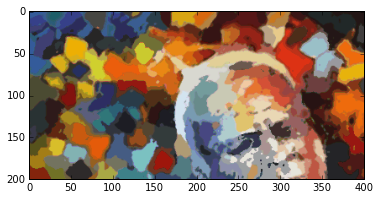

In [136]:
img_color = img_merged[[c for c in img_merged.columns if c.endswith('_m')]]
img_color = ops.reravel(img_color, *img_rgb.shape[0:2])
img_color = img_color / alpha
img_color = convert.lab_to_rgb(img_color)
img_color = fxn.denoise_raw_img(img_color, 1)
plt.imshow(img_color)
plt.imsave('/tmp/pbn_prelim.png', img_color)

## Collapse Colors

In [137]:
avg_color_cols = [c for c in img_merged.columns if c.endswith('_m')]

In [138]:
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

def collapse_colors(flt_cluster, color_cols, n_colors=10, alpha=1):
    X = flt_cluster[color_cols] / alpha
    mm = GMM(n_components=n_colors)
    y = pd.Series(mm.fit(X).predict(X))
    assert mm.converged_, 'Mixture model did not converge'
    mean_map = dict([ (i, v * alpha) for i, v in enumerate(mm.means_) ])
    flt_cluster[['{}_c'.format(c) for c in color_cols]] = y.map(mean_map).apply(pd.Series)
    flt_cluster['cc'] = y
    return flt_cluster.sort_index(), mm

## Normalize Colors to Clusters

In [139]:
img_clustered, mm = collapse_colors(img_merged, avg_color_cols, n_colors=20, alpha=alpha)
clustered_color_cols = [c for c in img_clustered.columns if c.endswith('_m_c')]

In [140]:
img_clustered.head()

,x,y,l,a,b,c,l_m,a_m,b_m,l_m_c,a_m_c,b_m_c,cc
order,,,,,,,,,,,,,
0,0,0,138.337586,17.246894,-164.449224,92,153.64673,9.840624,-158.245369,159.942509,7.117389,-114.016917,15
1,0,1,246.500256,-27.041969,-161.877610,85,155.99341,1.472549,-135.127070,159.942509,7.117389,-114.016917,15
2,0,2,181.279492,-9.070585,-160.252197,92,153.64673,9.840624,-158.245369,159.942509,7.117389,-114.016917,15
3,0,3,181.279492,-9.070585,-160.252197,92,153.64673,9.840624,-158.245369,159.942509,7.117389,-114.016917,15
4,0,4,161.636972,-1.464219,-158.473614,92,153.64673,9.840624,-158.245369,159.942509,7.117389,-114.016917,15


### Denoise Result

In [631]:
#img_denoised = fxn.denoise_flat_img(img_clustered, img_rgb.shape, ['l_m_c', 'a_m_c', 'b_m_c'], n_iter=3)
#denoise_color_cols = [c for c in img_denoised.columns if c.endswith('_dn')]
#print(denoise_color_cols)
#img_denoised.head()

,x,y,l,a,b,c,l_m,a_m,b_m,l_m_c,a_m_c,b_m_c,l_m_c_dn,a_m_c_dn,b_m_c_dn
order,,,,,,,,,,,,,,,
0,0,0,0.138338,0.017247,-0.164449,93,0.126329,0.040447,-0.152333,0.117821,0.041056,-0.144905,0.120044,0.052411,-0.14267
1,0,1,0.246500,-0.027042,-0.161878,93,0.126329,0.040447,-0.152333,0.117821,0.041056,-0.144905,0.120044,0.052411,-0.14267
2,0,2,0.181279,-0.009071,-0.160252,93,0.126329,0.040447,-0.152333,0.117821,0.041056,-0.144905,0.120044,0.052411,-0.14267
3,0,3,0.181279,-0.009071,-0.160252,93,0.126329,0.040447,-0.152333,0.117821,0.041056,-0.144905,0.120044,0.052411,-0.14267
4,0,4,0.161637,-0.001464,-0.158474,93,0.126329,0.040447,-0.152333,0.117821,0.041056,-0.144905,0.120044,0.052411,-0.14267


Index(['l_m_c', 'a_m_c', 'b_m_c'], dtype='object')


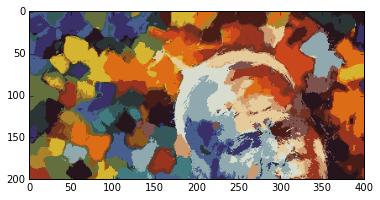

In [141]:
#img_color = img_denoised[denoise_color_cols]
img_color = img_clustered[clustered_color_cols]
print(img_color.columns)
img_color = ops.reravel(img_color, *img_rgb.shape[0:2])
img_color = img_color / alpha
img_color = convert.lab_to_rgb(img_color)
#img_color = denoise_raw_img(img_color, 1)
plt.imsave('/tmp/pbn_collapsed.png', img_color)
plt.imshow(img_color)

## Show Cluster Membership

In [142]:
def get_cluster_img(flt_cluster, img_d):
    """ expecting [ c, x, y, l, a, b ] where c is cluster and l, a, and b are color means """
    colors = {}
    res = np.empty_like(img_d)
    for cluster in flt_cluster['c'].unique():
        colors[cluster] = [np.random.rand(), np.random.rand(), np.random.rand()]
    for i, r in flt_cluster[['x', 'y', 'c']].iterrows():
        res[r['x'], r['y']] = colors[r['c']]
    return res

In [145]:
img_clusters = get_cluster_img(img_clustered, img_rgb)

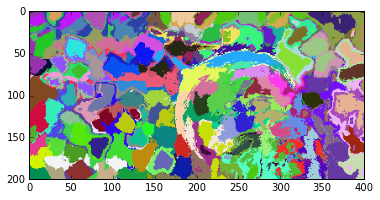

In [146]:
plt.imshow(img_clusters)

In [147]:
color_matrix = ops.reravel(img_clustered[['cc']], *img_rgb.shape[:2])
color_matrix = np.int64(np.reshape(color_matrix, img_rgb.shape[0:2]))
color_matrix.shape

(200, 400)

In [148]:
img_clustered.head()

,x,y,l,a,b,c,l_m,a_m,b_m,l_m_c,a_m_c,b_m_c,cc
order,,,,,,,,,,,,,
0,0,0,138.337586,17.246894,-164.449224,92,153.64673,9.840624,-158.245369,159.942509,7.117389,-114.016917,15
1,0,1,246.500256,-27.041969,-161.877610,85,155.99341,1.472549,-135.127070,159.942509,7.117389,-114.016917,15
2,0,2,181.279492,-9.070585,-160.252197,92,153.64673,9.840624,-158.245369,159.942509,7.117389,-114.016917,15
3,0,3,181.279492,-9.070585,-160.252197,92,153.64673,9.840624,-158.245369,159.942509,7.117389,-114.016917,15
4,0,4,161.636972,-1.464219,-158.473614,92,153.64673,9.840624,-158.245369,159.942509,7.117389,-114.016917,15


In [149]:
# Run this to make sure that the color clusters really only have one color per cluster
img_clustered.groupby('cc').apply(lambda x: len(x[['l_m_c', 'a_m_c', 'b_m_c']].drop_duplicates())).value_counts()
# This should report only "1" with a count equal to the number of clusters

1    20
dtype: int64

In [150]:
collapsed_color_clusters = img_clustered.groupby('cc')\
    .apply(lambda x: x[['l_m_c', 'a_m_c', 'b_m_c']].iloc[0])
collapsed_color_clusters.head()

,l_m_c,a_m_c,b_m_c
cc,,,
0,39.228837,44.239104,-9.368744
1,230.880279,34.728290,201.903208
2,192.839363,-75.650095,-35.889057
3,118.397811,110.429439,94.161734
4,70.388385,83.690774,55.709778


In [151]:
spatial_clusters = ops.cluster_by_proximity(color_matrix, threshold=.8, shrinkage=1, n_iterations=1)

379 clusters collapsed of 1408


In [152]:
[len(v) for v in spatial_clusters.values() ] 

[43,
 42,
 8,
 136,
 53,
 12,
 109,
 50,
 27,
 30,
 40,
 94,
 46,
 39,
 31,
 28,
 87,
 56,
 79,
 20]

In [153]:
import imp
imp.reload(convert)
imp.reload(ops)
imp.reload(fxn)

<module 'pbn.functions' from '/Users/eczech/repos/portfolio/functional/paint_by_numbers/python/pbn/functions.py'>

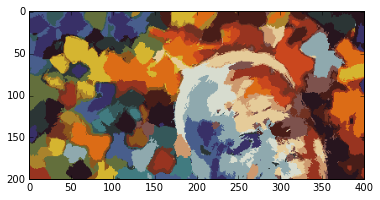

In [160]:
img_reassembled = ops.image_from_clusters(spatial_clusters, collapsed_color_clusters, img_rgb, use_random_color=False)
img_reassembled = convert.lab_to_rgb(img_reassembled / alpha)
plt.imsave('/tmp/pbn_rand.png', img_reassembled)
plt.imshow(img_reassembled)

In [718]:
img_reassembled.shape

(200, 400, 3)

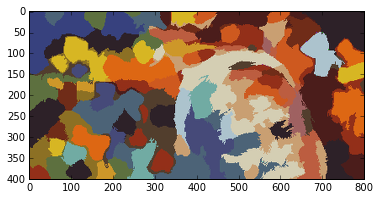

In [723]:
plt.imshow(scipy.ndimage.zoom(img_reassembled, (2, 2, 1)))

## D

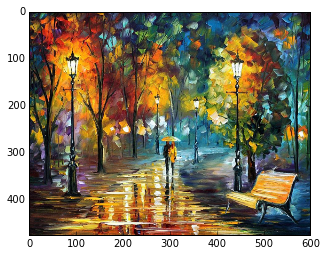

In [157]:
plt.imshow(img_d)

In [94]:
img_color[:1]

array([[[ 28.52951146,  41.8903634 ,  63.85973287],
        [ 28.52951146,  41.8903634 ,  63.85973287],
        [ 29.68364349,  26.02848577,  41.1074676 ],
        ..., 
        [ 19.85763937,  11.52777806,  19.85763943],
        [ 29.68364349,  26.02848577,  41.1074676 ],
        [ 38.47588722,  65.89200525,  86.06265656]]])